<a href="https://colab.research.google.com/github/Harshathout/harshathout-class/blob/main/Twitter_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [9]:
# Load the dataset
df = pd.read_csv('/content/twitter-stocks.csv')

# Display the first few rows of the dataset
print(df.head())


         Date       Open       High        Low      Close  Adj Close  \
0  2013-11-07  45.099998  50.090000  44.000000  44.900002  44.900002   
1  2013-11-08  45.930000  46.939999  40.685001  41.650002  41.650002   
2  2013-11-11  40.500000  43.000000  39.400002  42.900002  42.900002   
3  2013-11-12  43.660000  43.779999  41.830002  41.900002  41.900002   
4  2013-11-13  41.029999  42.869999  40.759998  42.599998  42.599998   

        Volume  
0  117701670.0  
1   27925307.0  
2   16113941.0  
3    6316755.0  
4    8688325.0  


In [17]:
# Sort data by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
# Use the 'Close' column for prediction
data = df['Close'].values

# Reshape and scale the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

# Define the training data length (80% for training, 20% for testing)
training_data_len = int(np.ceil(len(scaled_data) * 0.8))


In [8]:
df.columns

Index(['SYMBOL', 'SERIES', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'LAST', 'PREVCLOSE',
       'TOTTRDQTY', 'TOTTRDVAL', 'TIMESTAMP', 'TOTALTRADES', 'ISIN'],
      dtype='object')

In [19]:
# Create training dataset
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train for LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [20]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=10)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 52s 28ms/step - loss: 0.0034
Epoch 2/10
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 85s 29ms/step - loss: 7.4859e-04
Epoch 3/10
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 48s 27ms/step - loss: 7.4985e-04
Epoch 4/10
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 84s 29ms/step - loss: 7.8845e-04
Epoch 5/10
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 48s 27ms/step - loss: 7.3527e-04
Epoch 6/10
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 84s 28ms/step - loss: 5.8902e-04
Epoch 7/10
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - loss: 5.1832e-04
Epoch 8/10
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - loss: 5.1519e-04
Epoch 9/10
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - loss: 5.8321e-04
Epoch 10/10
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 83s 29ms/step - loss: 5.4296e-04


In [21]:
# Create the testing dataset
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = data[training_data_len:]  # Actual closing prices

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert x_test to a numpy array
x_test = np.array(x_test)

# Reshape x_test for LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get model predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [22]:
from sklearn.metrics import mean_squared_error
import math

# Calculate the RMSE
rmse = math.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 2.75262983225315


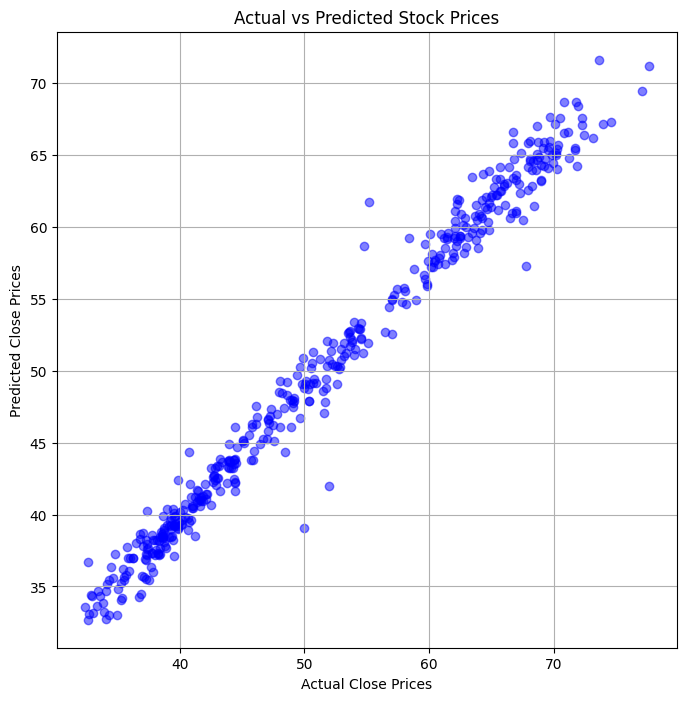

In [33]:
# Create a DataFrame called 'valid' with 'Close' and 'Predictions' columns
valid = pd.DataFrame({'Close': y_test, 'Predictions': predictions.flatten()}) # predictions.flatten() is used to ensure both series have same shape

# Scatter plot: Actual vs. Predicted prices
plt.figure(figsize=(8, 8))
plt.scatter(valid['Close'], valid['Predictions'], alpha=0.5, color='blue')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Actual Close Prices')
plt.ylabel('Predicted Close Prices')
plt.grid(True)
plt.show()